In [2]:
import numpy as np
import scipy as sp
import pandas as pd
import sklearn as sk
import PIL
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn import metrics
from collections import defaultdict
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.pipeline import make_pipeline
from time import time
from sklearn.svm import SVC
from os import listdir

from skimage.feature import hog
from skimage.io import imread
from skimage.transform import rescale
from sklearn.model_selection import train_test_split

In [3]:

! wget -O DATA.zip https://digitalcommons.usu.edu/context/all_datasets/article/1047/type/native/viewcontent
! unzip DATA.zip
! unzip DATA_Maguire_20180517_ALL/SDNET2018.zip

Streaming output truncated to the last 5000 lines.
  inflating: D/UD/7032-171.jpg       
  inflating: D/UD/7032-172.jpg       
  inflating: D/UD/7032-173.jpg       
  inflating: D/UD/7032-174.jpg       
  inflating: D/UD/7032-175.jpg       
  inflating: D/UD/7032-176.jpg       
  inflating: D/UD/7032-177.jpg       
  inflating: D/UD/7032-178.jpg       
  inflating: D/UD/7032-179.jpg       
  inflating: D/UD/7032-18.jpg        
  inflating: D/UD/7032-180.jpg       
  inflating: D/UD/7032-181.jpg       
  inflating: D/UD/7032-182.jpg       
  inflating: D/UD/7032-183.jpg       
  inflating: D/UD/7032-184.jpg       
  inflating: D/UD/7032-185.jpg       
  inflating: D/UD/7032-186.jpg       
  inflating: D/UD/7032-187.jpg       
  inflating: D/UD/7032-188.jpg       
  inflating: D/UD/7032-189.jpg       
  inflating: D/UD/7032-19.jpg        
  inflating: D/UD/7032-190.jpg       
  inflating: D/UD/7032-191.jpg       
  inflating: D/UD/7032-192.jpg       
  inflating: D/UD/7032-193.jpg       

In [3]:
cracked_labels = set()
labels = []
image_files = []
structures = ["D", "P", "W"]
for structure in structures:
    for label in ["U", "C"]:
        img_folder = structure + "/" + label + structure
        for filename in listdir(img_folder):
            if filename.endswith("jpg"):
                image_file = img_folder + "/" + filename
                #if label == "C":
                #    cracked_labels.add(image_file)
                image_files.append(image_file)
                #data = imread(img_folder + "/" + filename, as_gray=True)
                labels.append(label)
                #imgdata.append(data)
            else:
                print("bad name -> " + filename)



In [11]:
X_train_files, X_test_files, y_train, y_test = train_test_split(image_files, labels, test_size=0.4)  

In [16]:
def loadAndScaleImages(filelist):
  print("loadAndScaleImages")
  imgdata = []
  for file in filelist:
    data = imread(file, as_gray=True)
    data = rescale(data, 0.4)
    #plt.imshow(data, cmap=plt.cm.gray)
    imgdata.append(data.flatten())
  return np.array(imgdata)

def runPCA(X, n_c, plot=False):
  print("Running PCA")
  pca = PCA(n_components=n_c)
  pca.fit(X)
  if(plot):
    plt.plot(range(0, len(pca.explained_variance_ratio_)), np.cumsum(pca.explained_variance_ratio_))
  return pca

loadAndScaleImages
Running PCA


SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

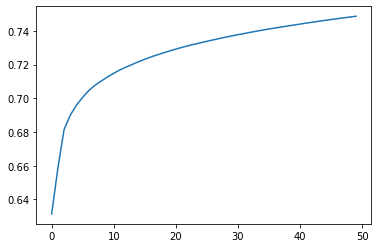

In [18]:
X_train = loadAndScaleImages(X_train_files)
pca = runPCA(X_train, 50, True)
X_train = pca.transform(X_train)
svc = SVC()
svc.fit(X_train, y_train)

In [19]:
X_test = loadAndScaleImages(X_test_files)
#pca = runPCA(X_test, 50, True)
X_test = pca.transform(X_test)
#y_predict = svc.predict(X_test)
svc.score(X_test, y_test)

loadAndScaleImages


0.8494005437447074